## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.


In [29]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib notebook

## First: camera calibration using chessboard images
This is a one-time cost so better do it separately from the rest of the pipeline

In [4]:
### parameters
nx=9
ny=6
#Calibrate camera
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((ny*nx,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)
# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.
# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')
# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny),None)
    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        # Draw and display the corners
        img = cv2.drawChessboardCorners(img,(nx,ny), corners, ret)
cv2.destroyAllWindows()
 
#extract camera matrix 1 distortion coefficients
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1::-1], None, None)

## Second: Image pipeline

### Read in images

This dimensions: (720, 1280, 3)


<IPython.core.display.Javascript object>


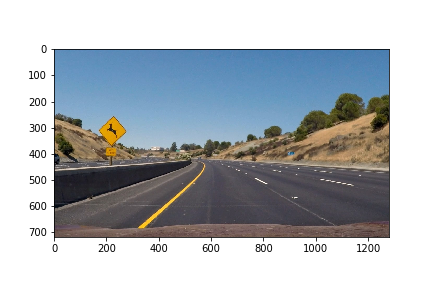

In [30]:
#reading in an image
image = mpimg.imread('./test_images/test2.jpg')
print('This dimensions:', image.shape)
%matplotlib notebook
plt.imshow(image)

### Helper functions

In [24]:
#1. Correct distortion : no function
#2. Create binary threshold image
def create_binary(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    return cv2.cvtColor(color_binary, cv2.COLOR_RGB2GRAY)

def gaussian_blur(img, kernel_size):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

#3. Warp image
def transform_perspective(img,nx,ny,src,offset=100):
    # Convert undistorted image to grayscale
    rgb=cv2.cvtColor(img,cv2.COLOR_HLS2RGB)
    gray=cv2.cvtColor(rgb,cv2.COLOR_RGB2GRAY)
    # Search for corners in the grayscaled image
    corners=np.array([])
    # Grab the image shape
    img_size = (gray.shape[1], gray.shape[0])
    dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                    [img_size[0]-offset, img_size[1]-offset], 
                    [offset, img_size[1]-offset]])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    # Warp the image using OpenCV warpPerspective()
    warped_img = cv2.warpPerspective(img, M, img_size)

    return warped_img, M, Minv

#4. Detect & fit lane lines
def find_fit_lane_lines(img,nwindows,margin,minpix):
    
    histogram=np.sum(img[int(img.shape[0]/2):img.shape[0],:],0)
    out_img = np.dstack((img,img,img))
    mid_point=int(histogram.shape[0]/2)
    leftx_base=np.argmax(histogram[:mid_point])
    rightx_base=np.argmax(histogram[mid_point:])+mid_point
    #x,y positions for non zero pixels
    window_height=img.shape[0]//nwindows
    non_zero=img.nonzero()
    non_zerox=np.array(non_zero[1])
    non_zeroy=np.array(non_zero[0])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # track curvature by iterating through nwindows
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current-margin
        win_xleft_high = leftx_current+margin
        win_xright_low = rightx_current-margin
        win_xright_high = rightx_current+margin
        # Draw the windows on the visualization image
        #cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2)
        #cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 

        #Identify the nonzero pixels in x and y within the window
        good_left_inds = ((non_zeroy >= win_y_low) & (non_zeroy <= win_y_high) &
                          (non_zerox >=  win_xleft_low) & (non_zerox <= win_xleft_high))
        good_left_inds=np.where(good_left_inds !=0)[0]
        good_right_inds = ((non_zeroy >= win_y_low) & (non_zeroy <= win_y_high) &
                           (non_zerox >=  win_xright_low) & (non_zerox <= win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        if len(good_left_inds)>minpix:
            leftx_current=np.int(np.mean(non_zerox[good_left_inds]))
        if len(good_right_inds)>minpix:
            rightx_current=np.int(np.mean(non_zerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass
    
    # Extract left and right line pixel positions
    leftx = non_zerox[left_lane_inds]
    lefty = non_zeroy[left_lane_inds] 
    rightx = non_zerox[right_lane_inds]
    righty = non_zeroy[right_lane_inds]
    
    # polynomial fit
    left_fit = np.polyfit(lefty,leftx,2)
    right_fit = np.polyfit(righty,rightx,2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    #out_img[lefty, leftx] = [255, 0, 0]
    #out_img[righty, rightx] = [0, 0, 255]
    #out_img[np.array(ploty,dtype=int),np.array(left_fitx,dtype=int)] = [255,255,0]
    #out_img[np.array(ploty,dtype=int),np.array(right_fitx,dtype=int)] = [255,255,0]
    
    left_plot=np.dstack((np.array(left_fitx,dtype=int),np.array(ploty,dtype=int)))
    cv2.polylines(out_img,[left_plot],False,(255,0,0),lineType=cv2.LINE_AA,thickness=15)
    right_plot=np.dstack((np.array(right_fitx,dtype=int),np.array(ploty,dtype=int)))
    cv2.polylines(out_img,[right_plot],False,(255,0,0),lineType=cv2.LINE_AA,thickness=15)

    return out_img
#5. Compute curvature & vehicle position
#6. Unwarp: no function 
#7. Output result
def weighted_img(img, initial_img, α=0.8, β=0.7, γ=0):
    return cv2.addWeighted(initial_img, α, img, β, γ)

### Pipeline function

In [55]:
def image_pipeline(img):
    
    imsize=(img.shape[1],img.shape[0])
    #### Parameters list
    #Camera params (loaded in 1st part): nx,ny,mtx,dist,rvecs,tvecs
    #gaussian blur
    kernel_size=9
    #distortion: no parameters
    #warp/unwarp image:
    offset=100
    src=np.float32([[542,485],[743,485],[1000,648],[317,648]]) # tight boundary around the road
    #src=np.float32([[450,500],[830,500],[1100,640],[300,640]]) # relaxed boundary
    #binary threshold image:
    col_thd=(200,255) #default=(170,255)
    x_thd=(30,80) #default=(20,100)
    #detect/fit lane lines
    nwindows = 9 
    margin = 40 
    minpix = 20 
    
    blurred=gaussian_blur(img,kernel_size)
    #undistort image
    undst = cv2.undistort(blurred, mtx, dist, None, mtx)
    #transform perspective
    warped,M,Minv=transform_perspective(undst,nx,ny,src,offset)
    #convert image to binary
    bin_im=create_binary(warped,col_thd,x_thd)
    #fit lane lines
    out_img=find_fit_lane_lines(bin_im,nwindows,margin,minpix)
    #unwarp
    unwarped=cv2.warpPerspective(out_img, Minv, imsize)
    #restor background
    res=weighted_img(unwarped,img)
    return res

### Run pipeline on image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


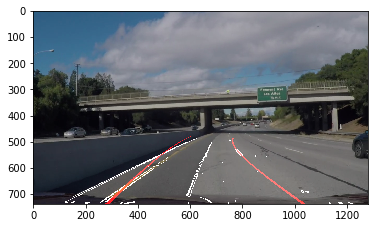

In [56]:
image = mpimg.imread('test_images/challenge_video.png')
im=image_pipeline(image)

%matplotlib inline
plt.imshow(im)
#plt.savefig('output_images/test6.jpg')

## Third: Video pipeline

In [33]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

(720, 1280, 3)


<IPython.core.display.Javascript object>


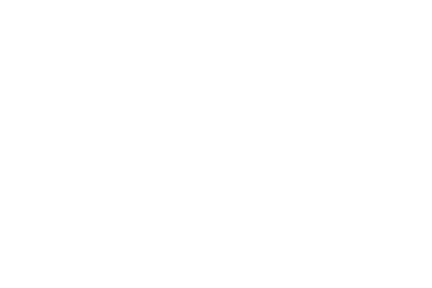

In [34]:
clip1 = VideoFileClip("test_videos/challenge_video.mp4").subclip(0,9)
im0=clip1.get_frame(10)
print(im0.shape)
%matplotlib notebook
plt.savefig('test_images/challenge_video.jpg')

In [58]:
white_output = 'output_videos/challenge_video.mp4'
clip1 = VideoFileClip("test_videos/challenge_video.mp4").subclip(0,9)
#clip1 = VideoFileClip("test_videos/project_video.mp4")
white_clip = clip1.fl_image(image_pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video output_videos/challenge_video.mp4
[MoviePy] Writing video output_videos/challenge_video.mp4


100%|██████████| 270/270 [00:35<00:00,  7.63it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/challenge_video.mp4 

CPU times: user 1min 16s, sys: 10.4 s, total: 1min 26s
Wall time: 36.7 s


In [59]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))